# Read Data

Download the 2022 Combined flight data .parquet file from here (https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022) into the ../data folder before running any code.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

columns = ["Cancelled", "DepDelayMinutes", "Distance", "Airline", "Dest", "DestStateName", "Origin", "OriginStateName", "DayOfWeek", "CRSDepTime", "DepTimeBlk", "Month"]

df = pd.read_parquet('../data/Combined_Flights_2022.parquet', columns=columns)

print(df.shape)

(4078318, 12)


# Construct New Columns

In [2]:
# Turn departure delay column into categorical features
df['OnTime'] = df['DepDelayMinutes'] == 0
df['SlightDelay'] = (df['DepDelayMinutes'] <= 15) & (df['DepDelayMinutes'] > 0)
df['MediumDelay'] = (df['DepDelayMinutes'] <= 45) & (df['DepDelayMinutes'] > 15)
df['LargeDelay'] = df['DepDelayMinutes'] > 45

# Make sure these categories are "one-hot" encoded
df.loc[df['Cancelled'], 'OnTime'] = False
df.loc[df['Cancelled'], 'SlightDelay'] = False
df.loc[df['Cancelled'], 'MediumDelay'] = False
df.loc[df['Cancelled'], 'LargeDelay'] = False

# Merge the columns into a single label
df['FlightStatus'] = df[['Cancelled','OnTime','SlightDelay','MediumDelay','LargeDelay']].idxmax(1).astype('category')

print(df.shape)

(4078318, 17)


# Splitting and Preprocessing 

In [3]:
# Check for missing values
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

# Replace NaN features with 0
df['DepDelayMinutes'] = df['DepDelayMinutes'].fillna(0)

fraction of missing values in features:
DepDelayMinutes    0.029545
dtype: float64


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score
import xgboost

X = df.drop(['Cancelled','OnTime','SlightDelay','MediumDelay','LargeDelay', 'DepDelayMinutes', 'FlightStatus'], axis=1)


y = df['FlightStatus']
label_encoder = OrdinalEncoder()
y = label_encoder.fit_transform(np.array(y).reshape(-1, 1)).reshape(-1)

nr_states = 1

test_scores = np.zeros(nr_states)
final_models = []

for i in range(nr_states):
    print('randoms state '+str(i+1))
    
    # first split to separate out the training set
    X_managable, _, y_managable, _ = train_test_split(X,y,train_size = 0.001,random_state=42*i)
    X_train, X_other, y_train, y_other = train_test_split(X_managable,y_managable,train_size = 0.95,random_state=42*i)

    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)
    
    # Preprocess features
    onehot_ftrs = ["Airline", "Dest", "DestStateName", "Origin", "OriginStateName", "DayOfWeek", "DepTimeBlk", "Month"]
    std_ftrs = ['Distance','CRSDepTime']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
            ('std', StandardScaler(), std_ftrs)])
    
    clf = Pipeline(steps=[('preprocessor', preprocessor)])
    
    X_train_prep = clf.fit_transform(X_train)
    X_val_prep = clf.transform(X_val)
    X_test_prep = clf.transform(X_test)
    
    # find the best parameter set
    param_grid = {"learning_rate": [0.03],
                  "n_estimators": [100, 1000, 10000],
                  "seed": [0], 
                  "max_depth": [1,3,10,30,100,],
                  "colsample_bytree": [0.9],              
                  "subsample": [0.66],
                  "eval_metric": [accuracy_score],
                 }
    
    # we save the train and validation scores
    # the validation scores are necessary to select the best model
    # it's optional to save the train scores, it can be used to identify high bias and high variance models
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        eval_set = [(X_val_prep, y_val)]
        XGB = xgboost.XGBClassifier(n_jobs=1, use_label_encoder=False, verbosity = 0)
        XGB.set_params(**params)
        XGB.fit(X_train_prep,y_train,early_stopping_rounds=50, eval_set=eval_set, verbose=False) # fit the model
        models.append(XGB) # save it
        # calculate train and validation accuracy scores
        y_train_pred = XGB.predict(X_train_prep)
        train_score[p] = accuracy_score(y_train,y_train_pred)
        y_val_pred = XGB.predict(X_val_prep)
        val_score[p] = accuracy_score(y_val,y_val_pred)
        print('   ',train_score[p],val_score[p])
    
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
    print('corresponding validation score:',np.max(val_score))
    # collect and save the best model
    final_models.append(models[np.argmax(val_score)])
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = accuracy_score(y_test,y_test_pred)
    print('test score:',test_scores[i])
        

randoms state 1
    0.5844088797108932 0.6176470588235294
    0.5844088797108932 0.6176470588235294
    0.5844088797108932 0.6176470588235294
    0.5900877645844089 0.5980392156862745
    0.596024780588539 0.5980392156862745
    0.596024780588539 0.5980392156862745
    0.6886938564790914 0.5980392156862745
    0.7039235931853381 0.5882352941176471
    0.7039235931853381 0.5882352941176471
    0.8691275167785235 0.5882352941176471
    0.8691275167785235 0.5882352941176471
    0.8691275167785235 0.5882352941176471
    0.9264326277749096 0.5686274509803921
    0.9264326277749096 0.5686274509803921
    0.9264326277749096 0.5686274509803921
best model parameters: {'subsample': 0.66, 'seed': 0, 'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.03, 'eval_metric': <function accuracy_score at 0x145b64550>, 'colsample_bytree': 0.9}
corresponding validation score: 0.6176470588235294
test score: 0.5490196078431373


OnTime         2398098
SlightDelay     722122
MediumDelay     445619
LargeDelay      389287
Cancelled       123192
Name: FlightStatus, dtype: int64
3.0    2398098
4.0     722122
2.0     445619
1.0     389287
0.0     123192
dtype: int64
[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False,
              eval_metric=<function accuracy_score at 0x145b64550>, gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, seed=0,
              subsample=0.66, tree_method='exact', use_label_encoder=False, ...)]
[4. 0. 2. 3. 3

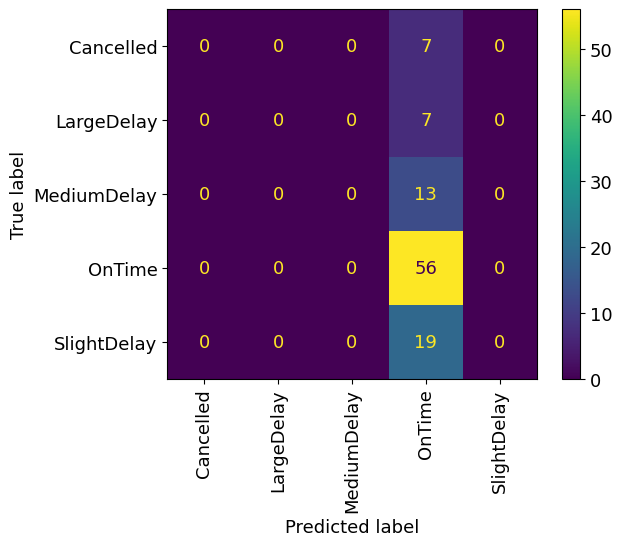

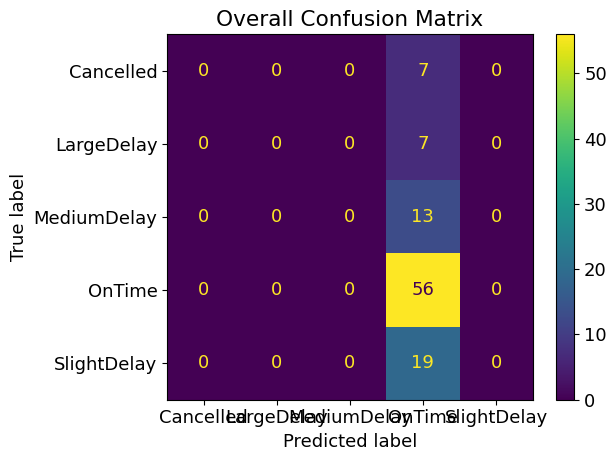

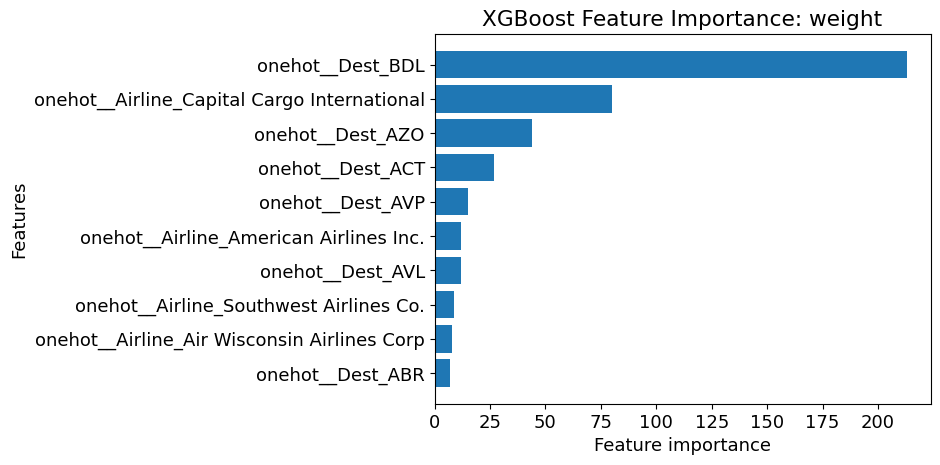

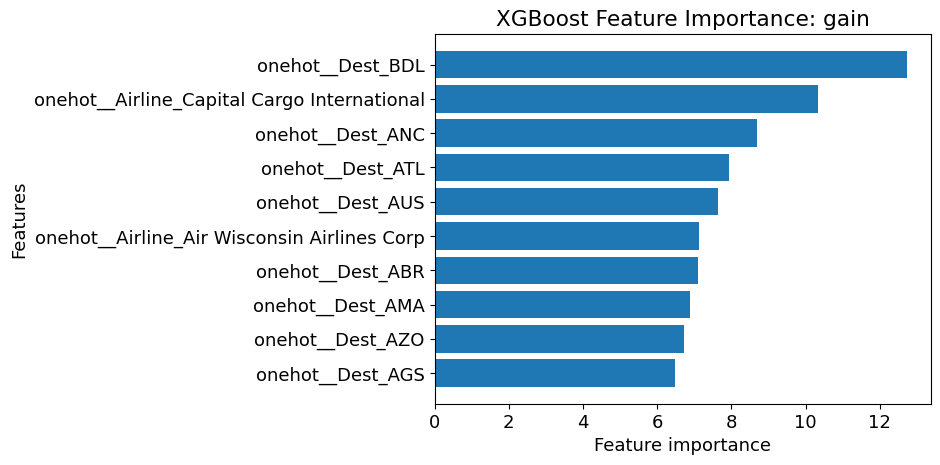

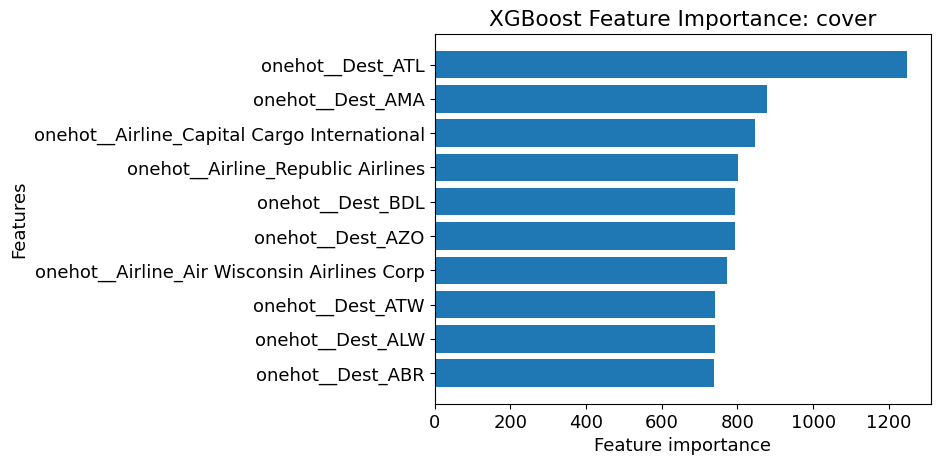

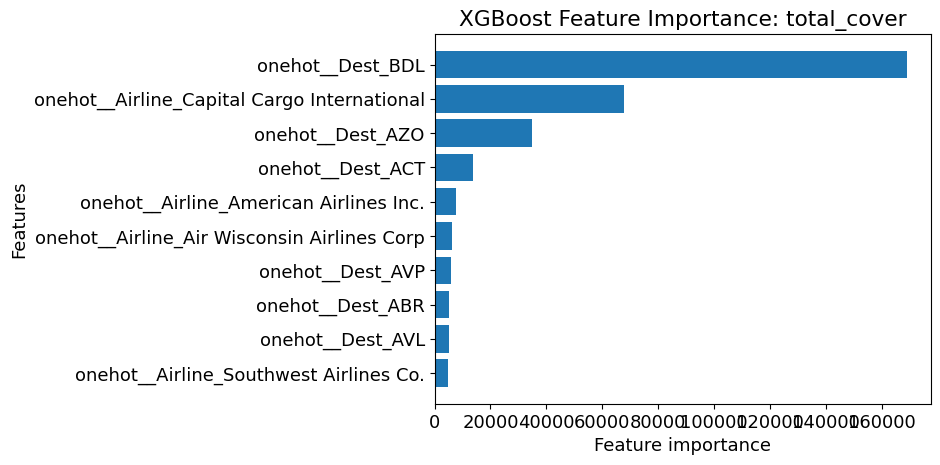

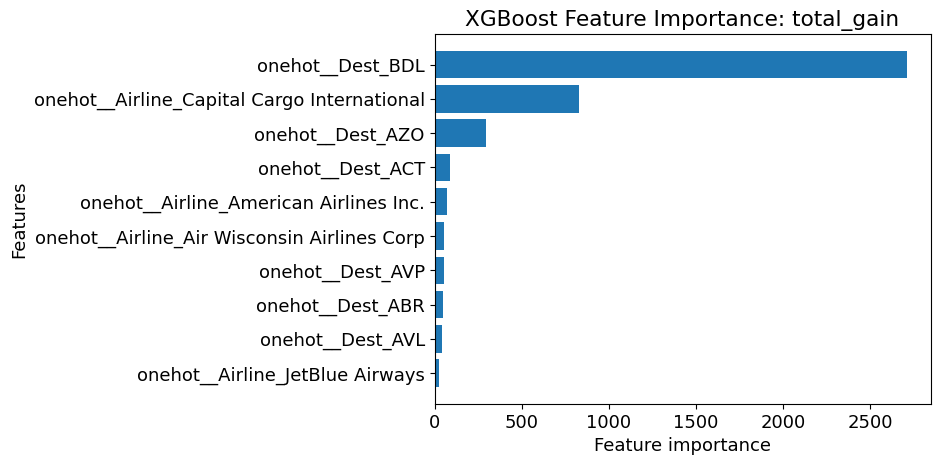

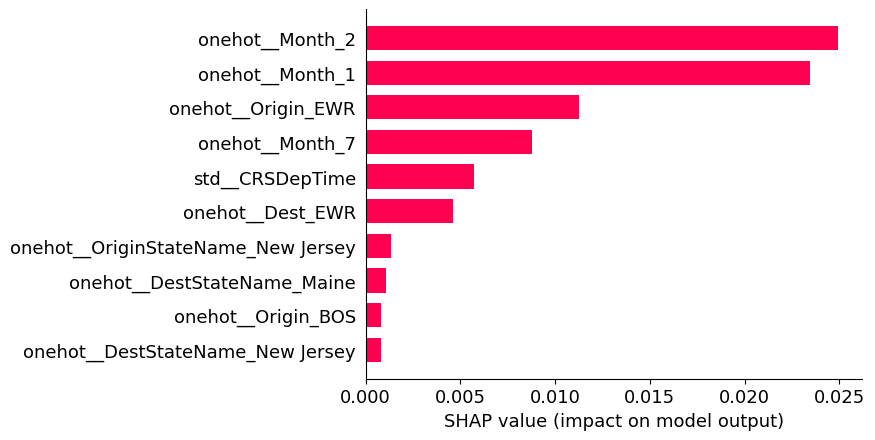

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

old_y = df['FlightStatus']
print(pd.value_counts(old_y))
print(pd.value_counts(y))

# first split to separate out the training set
i = 0
X_managable, _, y_managable, _ = train_test_split(X,y,train_size = 0.001,random_state=42*i)
X_train, X_other, y_train, y_other = train_test_split(X_managable,y_managable,train_size = 0.95,random_state=42*i)

# second split to separate out the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)

# Preprocess features
onehot_ftrs = ["Airline", "Dest", "DestStateName", "Origin", "OriginStateName", "DayOfWeek", "DepTimeBlk", "Month"]
std_ftrs = ['Distance','CRSDepTime']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

feature_names = np.array(preprocessor.get_feature_names_out())

print(final_models)
print(y_test)
print(y_pred)
y_pred = final_models[0].predict(X_test_prep)
disp = ConfusionMatrixDisplay.from_estimator(final_models[0], X_test_prep, y_test, display_labels=['Cancelled','LargeDelay','MediumDelay','OnTime','SlightDelay'], xticks_rotation='vertical')
disp.plot()
plt.title("Overall Confusion Matrix")
plt.tight_layout()
plt.show()


from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# test_score = 0.5490196078431373
# result = permutation_importance(final_models[0], X_test_prep, y_test, n_repeats=10, random_state=0)

# sorted_indcs = np.argsort(result.importances_mean)[::-1][:10][::-1]
# plt.rcParams.update({'font.size': 13})
# plt.figure(figsize=(6.4,4.8))
# plt.boxplot(test_score-result.importances[sorted_indcs].T, labels=feature_names[sorted_indcs], vert=False)
# plt.axvline(test_score, label='test score')
# plt.title("Permutation Importances (test set)")
# plt.xlabel('Score with perturbed feature')
# plt.ylabel("Features")
# plt.legend()
# plt.tight_layout()
# plt.show()

for type in ["weight", "gain", "cover", "total_cover", "total_gain"]:
    importances = final_models[0].get_booster().get_score(importance_type=type)
    importances_keys = np.array(list(importances.keys()))
    importances_values = np.array(list(importances.values()))
    sorted_indcs = np.argsort(importances_values)[::-1][:10][::-1]

    plt.barh(list(range(10)), importances_values[sorted_indcs], align='center')
    plt.yticks(list(range(10)), feature_names[sorted_indcs])
    plt.ylabel("Features")
    plt.xlabel("Feature importance")
    plt.title(f"XGBoost Feature Importance: {type}")
    plt.show()

import shap
shap.initjs()
explainer = shap.TreeExplainer(final_models[0])
shap_values = explainer.shap_values(X_test_prep)
shap.bar_plot(np.mean(np.abs(shap_values[0]), axis=0), feature_names=feature_names, max_display=10)

index = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = X_test_prep[index, :], feature_names = feature_names)

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

X = df.drop(['Cancelled','OnTime','SlightDelay','MediumDelay','LargeDelay', 'DepDelayMinutes', 'FlightStatus'], axis=1)


y = df['FlightStatus']
label_encoder = OrdinalEncoder()
y = label_encoder.fit_transform(np.array(y).reshape(-1, 1)).reshape(-1)

nr_states = 1

test_scores = np.zeros(nr_states)
final_models_lr = []

for i in range(nr_states):
    print('randoms state '+str(i+1))
    
    # first split to separate out the training set
    X_managable, _, y_managable, _ = train_test_split(X,y,train_size = 0.01,random_state=42*i)
    X_train, X_other, y_train, y_other = train_test_split(X_managable,y_managable,train_size = 0.95,random_state=42*i)

    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)
    
    # Preprocess features
    onehot_ftrs = ["Airline", "Dest", "DestStateName", "Origin", "OriginStateName", "DayOfWeek", "DepTimeBlk", "Month"]
    std_ftrs = ['Distance','CRSDepTime']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
            ('std', StandardScaler(), std_ftrs)])
    
    clf = Pipeline(steps=[('preprocessor', preprocessor)])
    
    X_train_prep = clf.fit_transform(X_train)
    X_val_prep = clf.transform(X_val)
    X_test_prep = clf.transform(X_test)
    
    # find the best parameter set
    param_grid = {"penalty": ['l2', 'none'],
                  "C": [0.1, 0.5, 0.9],
                  "n_jobs": [-1],
                  "max_iter": [10000],
                 }
    
    # we save the train and validation scores
    # the validation scores are necessary to select the best model
    # it's optional to save the train scores, it can be used to identify high bias and high variance models
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        eval_set = [(X_val_prep, y_val)]
        clf = LogisticRegression(random_state=0)
        clf.set_params(**params)
        clf.fit(X_train_prep,y_train) # fit the model
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train_prep)
        train_score[p] = accuracy_score(y_train,y_train_pred)
        y_val_pred = clf.predict(X_val_prep)
        val_score[p] = accuracy_score(y_val,y_val_pred)
        print('   ',train_score[p],val_score[p])
    
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
    print('corresponding validation score:',np.max(val_score))
    # collect and save the best model
    final_models_lr.append(models[np.argmax(val_score)])
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = accuracy_score(y_test,y_test_pred)
    print('test score:',test_scores[i])
        

randoms state 1
    0.5975789174818676 0.6098039215686275


KeyboardInterrupt: 

In [29]:
print(pd.value_counts(old_y)['OnTime']/len(old_y))

0.5880115282820025


[LogisticRegression(C=0.1, max_iter=10000, n_jobs=-1, random_state=0)]
[3. 3. 3. ... 3. 3. 3.]
[3. 3. 3. ... 3. 3. 3.]


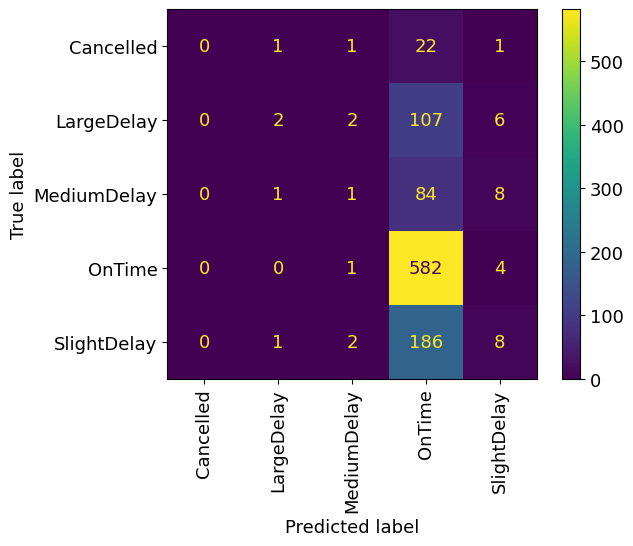

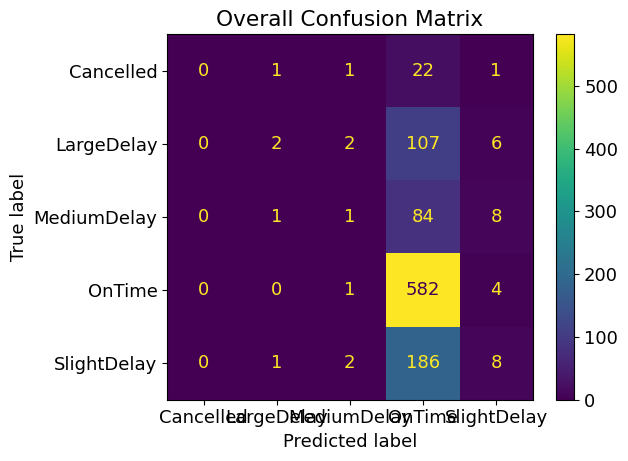

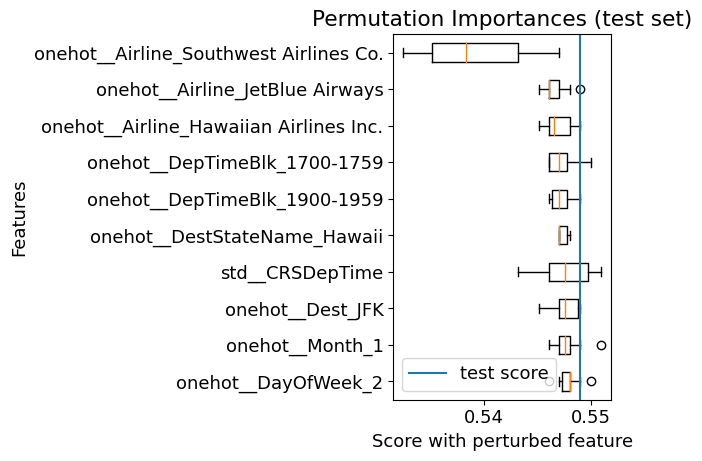

In [56]:
# first split to separate out the training set
i = 0
X_managable, _, y_managable, _ = train_test_split(X,y,train_size = 0.01,random_state=42*i)
X_train, X_other, y_train, y_other = train_test_split(X_managable,y_managable,train_size = 0.95,random_state=42*i)

# second split to separate out the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)

# Preprocess features
onehot_ftrs = ["Airline", "Dest", "DestStateName", "Origin", "OriginStateName", "DayOfWeek", "DepTimeBlk", "Month"]
std_ftrs = ['Distance','CRSDepTime']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

print(models)
print(y_test)
print(y_pred)
y_pred = models[0].predict(X_test_prep)
disp = ConfusionMatrixDisplay.from_estimator(models[0], X_test_prep, y_test, display_labels=['Cancelled','LargeDelay','MediumDelay','OnTime','SlightDelay'], xticks_rotation='vertical')
disp.plot()
plt.title("Overall Confusion Matrix")
plt.tight_layout()
plt.show()

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

result = permutation_importance(models[0], X_test_prep, y_test, n_repeats=10, random_state=0)
feature_names = np.array(preprocessor.get_feature_names_out())
sorted_indcs = np.argsort(result.importances_mean)[::-1][:10][::-1]
plt.rcParams.update({'font.size': 13})
plt.boxplot(test_score-result.importances[sorted_indcs].T, labels=feature_names[sorted_indcs], vert=False)
plt.axvline(test_score, label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('Score with perturbed feature')
plt.ylabel("Features")
plt.legend()
plt.tight_layout()
plt.show()
